# Modeling

Train and tune machine learning models.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
import sys
sys.path.append('..')

from project_setup import Visualizer, FeatureEngineer, DataManager,ModelManager

%matplotlib inline
sns.set_theme(style='whitegrid')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)

import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Load Data

In [2]:
# Load your data here
dm = DataManager()
mm = ModelManager()
v = Visualizer()
fe = FeatureEngineer()
df = dm.load('../data/processed/cleaned_data.csv')

📂 File: cleaned_data.csv
🔍 Detected encoding: ascii (100.0%)
✅ Loaded 546 rows and 13 columns
📋 Column names:
    1. indexcore
    2. price
    3. lotsize
    4. bedrooms
    5. bathrms
    6. stories
    7. driveway
    8. recroom
    9. fullbase
   10. gashw
   11. airco
   12. garagepl
   13. prefarea


# Model

In [3]:
# Select features for modeling
print("\n1️⃣ Feature Selection")
print("-" * 70)

# Identify numeric columns (exclude target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove price from features (it's our target)
if 'price' in numeric_cols:
    numeric_cols.remove('price')

# Remove any ID columns
id_cols = [col for col in numeric_cols if 'id' in col.lower() or 'ID' in col or 'indexcore' in col]
for col in id_cols:
    if col in numeric_cols:
        numeric_cols.remove(col)

print(f"Numeric features selected: {numeric_cols}")

# Select categorical columns to encode
df, encoders = mm.encode_categorical(
    df
)

# Get the encoded categorical column names
categorical_cols = [col for col in df.columns if '_encoded' in col and col not in numeric_cols]
print(f"Categorical features (encoded): {categorical_cols}")




1️⃣ Feature Selection
----------------------------------------------------------------------
Numeric features selected: ['lotsize', 'bedrooms', 'bathrms', 'stories', 'garagepl']
🔍 Auto-detected 6 categorical columns
🔄 Encoding 6 categorical columns using 'label' strategy
✓   Label encoded 'driveway' (2 classes)
✓   Label encoded 'recroom' (2 classes)
✓   Label encoded 'fullbase' (2 classes)
✓   Label encoded 'gashw' (2 classes)
✓   Label encoded 'airco' (2 classes)
✓   Label encoded 'prefarea' (2 classes)
✅ Encoding complete. New shape: (546, 13)
Categorical features (encoded): ['driveway_encoded', 'recroom_encoded', 'fullbase_encoded', 'gashw_encoded', 'airco_encoded', 'prefarea_encoded']


In [4]:
# Prepare features
print("\n2️⃣ Preparing Features")
print("-" * 70)

# Create a copy for modeling
df_model = df.copy()

# Handle any remaining missing values
df_model = df_model.dropna(subset=['price'] + numeric_cols)

# Create feature matrix X and target y
# categorical_cols already contains the encoded column names
feature_cols = numeric_cols + categorical_cols
X = df_model[feature_cols]
y = df_model['price']

print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"\n📊 Target variable (Prices) statistics:")
print(f"  Mean: ${y.mean():.2f}")
print(f"  Median: ${y.median():.2f}")
print(f"  Std Dev: ${y.std():.2f}")
print(f"  Min: ${y.min():.2f}")
print(f"  Max: ${y.max():.2f}")


2️⃣ Preparing Features
----------------------------------------------------------------------

✓ Feature matrix shape: (546, 11)
✓ Target shape: (546,)

📊 Target variable (Prices) statistics:
  Mean: $68121.60
  Median: $62000.00
  Std Dev: $26702.67
  Min: $25000.00
  Max: $190000.00


In [5]:


# Split data
print("\n3️⃣ Splitting Data")
print("-" * 70)

X_train, X_test, y_train, y_test = mm.train_test_split(
    X, y, test_size=0.2
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Scale features
print("\n4️⃣ Scaling Features")
print("-" * 70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")


3️⃣ Splitting Data
----------------------------------------------------------------------
✅ Split data: Train=436, Test=110
Training set: 436 samples
Test set: 110 samples

4️⃣ Scaling Features
----------------------------------------------------------------------
✓ Features scaled using StandardScaler


In [6]:


print("\n5️⃣ Training Multiple Models")
print("-" * 70)

# Dictionary to store results
results = {}

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    # Store results
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': test_rmse,
        'mae': test_mae,
        'mape': test_mape,
        'predictions': y_pred_test
    }
    
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  RMSE:     ${test_rmse:.2f}")
    print(f"  MAE:      ${test_mae:.2f}")
    print(f"  MAPE:     {test_mape:.2f}%")


5️⃣ Training Multiple Models
----------------------------------------------------------------------

Training Linear Regression...
  Train R²: 0.6827
  Test R²:  0.6160
  RMSE:     $16016.40
  MAE:      $11463.14
  MAPE:     19.12%

Training Ridge Regression...
  Train R²: 0.6827
  Test R²:  0.6162
  RMSE:     $16012.67
  MAE:      $11458.19
  MAPE:     19.12%

Training Lasso Regression...
  Train R²: 0.6827
  Test R²:  0.6160
  RMSE:     $16016.22
  MAE:      $11462.80
  MAPE:     19.12%

Training Decision Tree...
  Train R²: 0.9670
  Test R²:  0.2306
  RMSE:     $22671.43
  MAE:      $15934.08
  MAPE:     24.63%

Training Random Forest...
  Train R²: 0.9289
  Test R²:  0.5364
  RMSE:     $17599.08
  MAE:      $12740.17
  MAPE:     20.54%

Training Gradient Boosting...
  Train R²: 0.9540
  Test R²:  0.5186
  RMSE:     $17932.85
  MAE:      $12616.69
  MAPE:     20.43%


In [7]:


print("\n" + "=" * 70)
print("📊 MODEL COMPARISON")
print("=" * 70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'RMSE': [results[m]['rmse'] for m in results],
    'MAE': [results[m]['mae'] for m in results],
    'MAPE (%)': [results[m]['mape'] for m in results]
})

comparison_df = comparison_df.sort_values('Test R²', ascending=False)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R² Score: {comparison_df.iloc[0]['Test R²']:.4f}")


📊 MODEL COMPARISON
            Model  Train R²  Test R²         RMSE          MAE  MAPE (%)
 Ridge Regression  0.682710 0.616203 16012.672021 11458.185870 19.116620
 Lasso Regression  0.682712 0.616032 16016.224264 11462.795750 19.122053
Linear Regression  0.682712 0.616024 16016.397426 11463.135922 19.122622
    Random Forest  0.928949 0.536388 17599.083555 12740.174061 20.537912
Gradient Boosting  0.953963 0.518637 17932.847543 12616.685669 20.425314
    Decision Tree  0.966960 0.230635 22671.432131 15934.083432 24.632894

🏆 Best Model: Ridge Regression
   Test R² Score: 0.6162



📈 FEATURE IMPORTANCE

Top 10 Most Important Features:
         Feature  Importance
         lotsize    0.490521
         bathrms    0.118738
        garagepl    0.084252
   airco_encoded    0.071880
         stories    0.059172
        bedrooms    0.048760
fullbase_encoded    0.036241
prefarea_encoded    0.030749
 recroom_encoded    0.024120
   gashw_encoded    0.022209


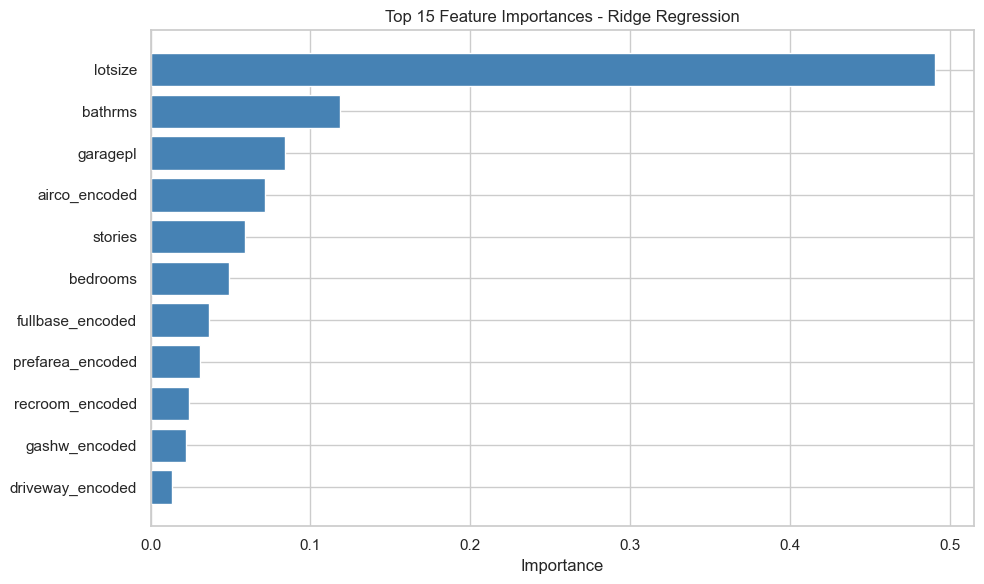

In [8]:
print("\n" + "=" * 70)
print("📈 FEATURE IMPORTANCE")
print("=" * 70)

# Get feature importance from best tree-based model
if 'Random Forest' in results or 'Gradient Boosting' in results:
    importance_model = results.get('Random Forest', results.get('Gradient Boosting'))['model']
    
    if hasattr(importance_model, 'feature_importances_'):
        importances = importance_model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['Importance'],color = "steelblue")
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance')
        plt.title(f'Top 15 Feature Importances - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()



🎯 PREDICTIONS VS ACTUAL


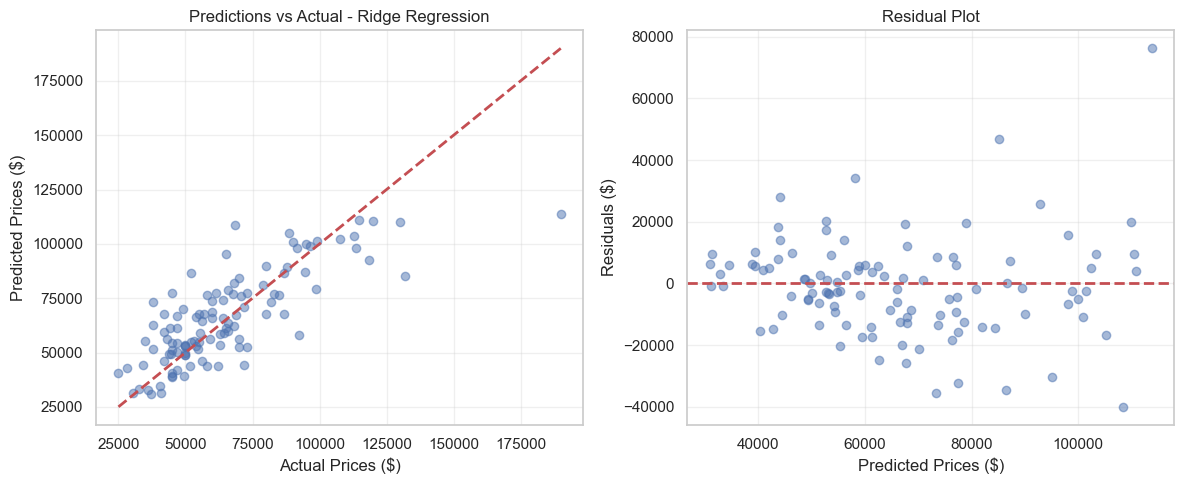

In [9]:


print("\n" + "=" * 70)
print("🎯 PREDICTIONS VS ACTUAL")
print("=" * 70)

# Plot for best model
best_predictions = results[best_model_name]['predictions']

plt.figure(figsize=(12, 5))

# Subplot 1: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.title(f'Predictions vs Actual - {best_model_name}')
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()


Top 10 Most Important Features:
         Feature  Importance
         lotsize    0.490521
         bathrms    0.118738
        garagepl    0.084252
   airco_encoded    0.071880
         stories    0.059172
        bedrooms    0.048760
fullbase_encoded    0.036241
prefarea_encoded    0.030749
 recroom_encoded    0.024120
   gashw_encoded    0.022209


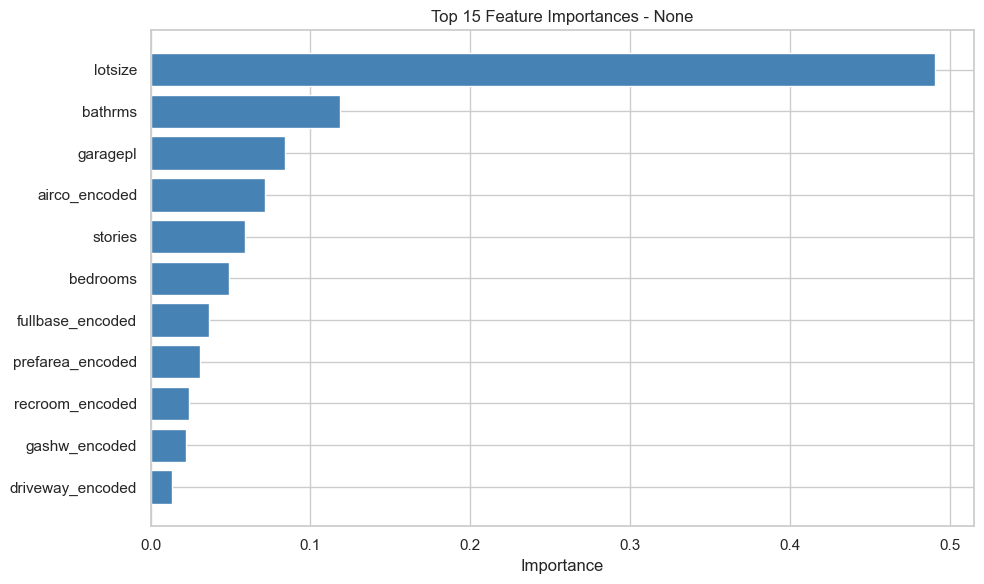

In [10]:
v.feature_importance(importance = feature_importance['Importance'].values,feature_names= feature_importance['Feature'].values,results= results,feature_cols=feature_cols)

✅ Figure saved: reports\figures\residuals.png


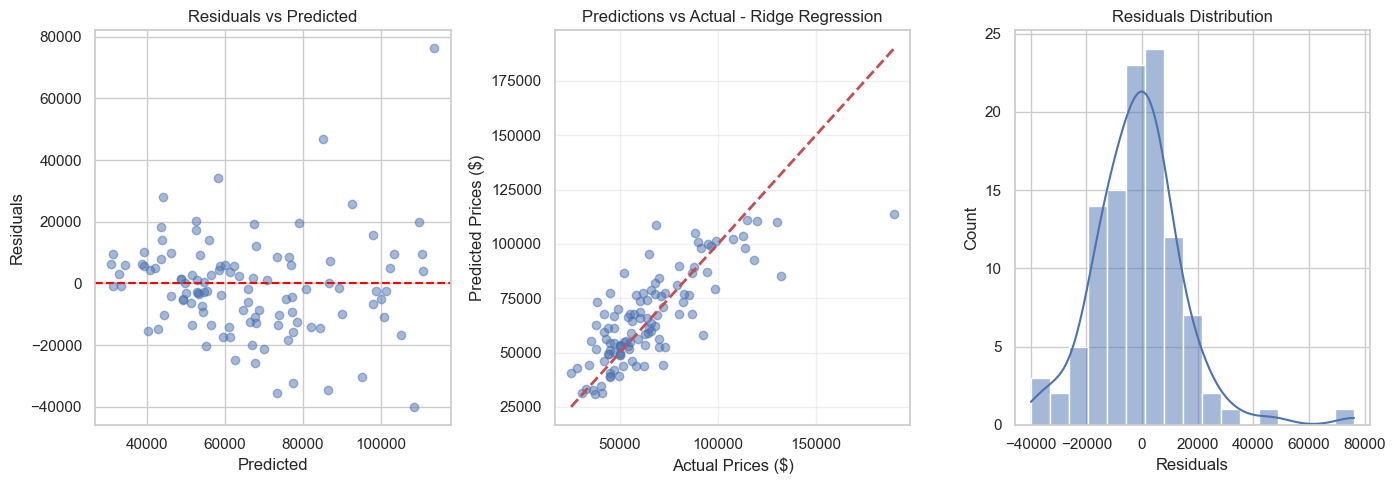

In [11]:
v.residuals(y_test=y_test,y_pred=best_predictions,best_model_name=best_model_name)

In [12]:


print("\n" + "=" * 70)
print("🔄 CROSS-VALIDATION (5-Fold)")
print("=" * 70)

cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nModel: {best_model_name}")
print(f"CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


🔄 CROSS-VALIDATION (5-Fold)

Model: Ridge Regression
CV Scores: ['0.7415', '0.5629', '0.5892', '0.6894', '0.6082']
Mean CV R² Score: 0.6382 (+/- 0.1335)


In [13]:
mm.save_model(filepath = '../models/sales_prediction_model.pkl',model = best_model)

✅ Model saved to: ..\models\sales_prediction_model.pkl


In [14]:
df.columns

Index(['indexcore', 'price', 'lotsize', 'bedrooms', 'bathrms', 'stories',
       'garagepl', 'driveway_encoded', 'recroom_encoded', 'fullbase_encoded',
       'gashw_encoded', 'airco_encoded', 'prefarea_encoded'],
      dtype='object')

In [15]:


print("\n" + "=" * 70)
print("📋 FINAL MODEL SUMMARY")
print("=" * 70)

print(f"""
Model Type: {best_model_name}
Training Samples: {X_train.shape[0]:,}
Test Samples: {X_test.shape[0]:,}
Number of Features: {X_train.shape[1]}

Performance Metrics:
  - R² Score: {comparison_df.iloc[0]['Test R²']:.4f}
  - RMSE: ${comparison_df.iloc[0]['RMSE']:.2f}
  - MAE: ${comparison_df.iloc[0]['MAE']:.2f}
  - MAPE: {comparison_df.iloc[0]['MAPE (%)']:.2f}%

Interpretation:
  - The model explains {comparison_df.iloc[0]['Test R²']*100:.1f}% of variance in prices
  - Average prediction error: ${comparison_df.iloc[0]['MAE']:.2f}
  - Predictions are typically off by {comparison_df.iloc[0]['MAPE (%)']:.1f}%

Next Steps:
  1. Use model for prices predictions
  2. Create visualizations in 05_visualization.ipynb
  3. Deploy model for production use
""")

print("=" * 70)
print("✅ MODELING COMPLETE!")
print("=" * 70)


📋 FINAL MODEL SUMMARY

Model Type: Ridge Regression
Training Samples: 436
Test Samples: 110
Number of Features: 11

Performance Metrics:
  - R² Score: 0.6162
  - RMSE: $16012.67
  - MAE: $11458.19
  - MAPE: 19.12%

Interpretation:
  - The model explains 61.6% of variance in prices
  - Average prediction error: $11458.19
  - Predictions are typically off by 19.1%

Next Steps:
  1. Use model for prices predictions
  2. Create visualizations in 05_visualization.ipynb
  3. Deploy model for production use

✅ MODELING COMPLETE!
